In [18]:
import requests
import pandas as pd
import string
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity as cos_sim



In [2]:
pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.5 MB/s eta 0:00:00


In [3]:
from keras_preprocessing.sequence import pad_sequences

For new users, our goal is to provide personalized recommendations based on their preferences and tastes. To achieve this, we will ask them to input information such as their preferred
ingredients. With this information, our algorithm will generate a set of recommended products on the menu that best match their preferences. We used fasttext embeddings so that the model could account for semantics of the user's input.

Loading and preprocessing the data that was scraped using  CocktailDB API


In [5]:
cocktail_df = df = pd.read_csv('CocktailDB.csv')
df = cocktail_df.loc[:,['Cocktail Name','Ingredients']]

In [6]:
cocktail_df.head()

,Unnamed: 0,Cocktail Name,Recipe,Ingredients,Proportions
0,0,155 Belmont,"1 shot Orange juice, 1 shot Vodka, 2 shots Lig...","Orange juice, Vodka, Light rum, Dark rum","1 shot , 1 shot , 2 shots , 1 shot"
1,1,1-900-FUK-MEUP,"1/4 oz Pineapple juice, 1/2 oz Cranberry juice...","Pineapple juice, Cranberry juice, Amaretto, Ma...","1/4 oz , 1/2 oz , 1/4 oz , 1/4 oz , 1/4 oz , 1..."
2,2,110 in the shade,"1.5 oz Tequila, 16 oz Lager","Tequila, Lager","1.5 oz , 16 oz"
3,3,151 Florida Bushwacker,"1 cup Vanilla ice-cream, 1 oz Coconut liqueur,...","Vanilla ice-cream, Coconut liqueur, Milk, Coin...","1 cup , 1 oz , 3 oz , 1 oz , 1 oz , 1/2 oz Bac..."
4,4,252,"1/2 shot Wild Turkey, 1/2 shot Bacardi 151 pro...","Wild Turkey, 151 proof rum","1/2 shot , 1/2 shot Bacardi"


In [7]:
df = cocktail_df.loc[:,['Cocktail Name','Ingredients']]

In [9]:

df['Ingredients'] = df['Ingredients'].str.split(',')

# get all unique values in the 'Ingredients' column
unique_values = df['Ingredients'].explode().unique()

num_unique_values = len(unique_values)
print('Unique values:', unique_values)
print('Number of unique values:', num_unique_values)

Unique values: ['Orange juice' ' Vodka' ' Light rum' ' Dark rum' 'Pineapple juice'
 ' Cranberry juice' ' Amaretto' ' Malibu rum' ' Midori melon liqueur'
 ' Chambord raspberry liqueur' ' Grand Marnier' ' Absolut Kurant'
 'Tequila' ' Lager' 'Vanilla ice-cream' ' Coconut liqueur' ' Milk'
 ' Cointreau' ' Dark Creme de Cacao' ' 151 proof rum' 'Wild Turkey'
 '151 proof rum' ' Rumple Minze' ' Jägermeister' ' Goldschlager'
 'Jim Beam' ' Johnnie Walker' ' Jack Daniels' 'Lemon' ' Bitters'
 ' Sweet and sour' ' Coca-Cola' ' Triple sec' ' Tequila' ' Gin'
 'Coca-Cola' ' Peach Vodka' ' Vanilla vodka' '7-Up' ' Sour mix'
 ' Blueberry schnapps' ' Blue Curacao' 'Vodka' ' Creme de Cacao'
 'Lemon juice' ' 7-Up' 'Frangelico' ' Baileys irish cream' ' Kahlua'
 'Sprite' ' Cranberry Juice' ' Roses sweetened lime juice'
 ' Strawberry liqueur' ' Orange Curacao' ' Absolut Citron' 'Grenadine'
 ' Lemon Juice' 'Cognac' 'Egg White' ' Heavy cream' ' Grenadine'
 ' Lemon juice' 'Tonic water' ' Absolut Vodka' 'Grapefruit 

In [10]:
# Preprocess the Ingredients column


unique_ingredients = list(set([ingredient for ingredients in df['Ingredients'] for ingredient in ingredients]))
df['All_Ingredients'] = pd.Series([unique_ingredients]*len(df))

# Encode the data using one-hot encoding
for ingredient in unique_ingredients:
    df[ingredient] = df['Ingredients'].apply(lambda x: int(ingredient in x))


<ipython-input-10-b47f2ba59867>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ingredient] = df['Ingredients'].apply(lambda x: int(ingredient in x))
<ipython-input-10-b47f2ba59867>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ingredient] = df['Ingredients'].apply(lambda x: int(ingredient in x))
<ipython-input-10-b47f2ba59867>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [11]:
import numpy as np
#create a new column for each ingredient 
for ingredient in unique_ingredients:
    df[ingredient] = np.zeros(len(df))

for i, row in df.iterrows():
    for ingredient in row['Ingredients']:
        df.at[i, ingredient] = 1

Analyzing the data

The optimal number of clusters is typically the one that maximizes the silhouette score, which in this case appears to be aroung 8 or 9 clusters. Other method suggested 5 clusters.


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

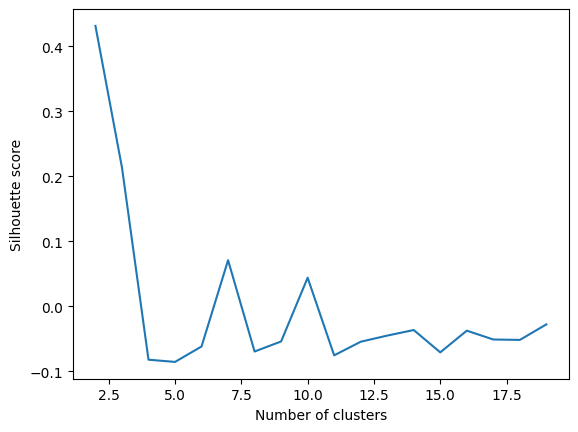

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Scale the data to have mean=0 and variance=1
scaler = StandardScaler()
X = scaler.fit_transform(df[unique_ingredients])

# Try different numbers of clusters and compute the average silhouette score
silhouette_scores = []
for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

import matplotlib.pyplot as plt
plt.plot(range(2, 20), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [13]:
unique_values = pd.DataFrame(unique_values)

In [14]:
ingredient_data = unique_values

In [16]:
unique_values[:][0]=unique_values[:][0].apply(str. lower)

In [17]:
unique_values.to_csv("ingredients.txt", header=None, index=None, sep=',', mode='w')

In [19]:
ingredient_data = ingredient_data.rename(columns={0:'ingredient_name'})

Loading FastText pretrained embeddings

In [ ]:
# Install FasText
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText/.
# Load model
import fastText
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English



Cloning into 'fastText'...
remote: Enumerating objects: 3930, done.
remote: Counting objects: 100% (944/944), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 3930 (delta 854), reused 804 (delta 804), pack-reused 2986
Receiving objects: 100% (3930/3930), 8.24 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (2505/2505), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./fastText
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4388107 sha256=782866510b25e042970b634b4a71dab82a35e418d6ec70d70b175228fcfd7134
  Stored in directory: /tmp/pip-ephem-wheel-cache-xyn_h8dj/wheels/a4/2f/6a/91d479a807787e092f667baec5df08801b0558f5676427f5a9
Successfully built fasttext



'cc.en.300.bin'

In [ ]:
english_model = fasttext.load_model('cc.en.300.bin')

In [ ]:
english_model.get_dimension()

300

In [ ]:
fasttext.util.reduce_model(english_model, 100)

In [ ]:
# Generate ingredient embeddings
ingredient_embeddings = {}
for ingredient in ingredient_data['ingredient_name']:
    ingredient_embeddings[ingredient] = english_model.get_word_vector(ingredient)



In [ ]:
# Preprocess the Ingredients column #stemming made recommendations worse
cocktail_df['Ingredients'] = cocktail_df['Ingredients'].str.lower()


Generating embeddings for the ingredients using Fasttext

In [ ]:
# Generate recipe embeddings
recipe_embeddings = {}
for index, row in cocktail_df.iterrows():
    recipe_name = row['Cocktail Name']
    recipe_ingredients = row['Ingredients'].split(',')
    recipe_embedding = np.zeros(100) # FastText embeddings are 100-dimensional
    for ingredient in recipe_ingredients:
        if ingredient in ingredient_embeddings:
            recipe_embedding += ingredient_embeddings[ingredient]
    recipe_embedding /= len(recipe_ingredients)
    recipe_embeddings[recipe_name] = recipe_embedding

user_embedding = np.zeros(100)

# Specify user's preferred ingredients
user_ingredients = ['mint','vodka']
user_ingredients = [ingredient.lower() for ingredient in user_ingredients] # convert to lowercase



for ingredient in user_ingredients:
    if ingredient in ingredient_embeddings:
        user_embedding += ingredient_embeddings[ingredient]
    else:
        user_embedding += english_model.get_word_vector(ingredient)
user_embedding /= len(user_ingredients)

# Generate recipe recommendations based on new user embedding
recommendations = []
for recipe_name, recipe_embedding in recipe_embeddings.items():
    similarity = cos_sim([user_embedding], [recipe_embedding])[0][0]
    recommendations.append((recipe_name, similarity))

recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
recommended_recipe_names = [r[0] for r in recommendations]

Generating recommendation for the input "mint, vodka"


In [ ]:
if len(recommendations) > 0:
    print('Top 3 recommended drinks:')
    for i, recommendation in enumerate(recommendations[:3]):
        drink_name = recommendation[0]
        score = recommendation[1]
        print(f"{i+1}. {drink_name} (score: {score:.2f})")
else:
    print('No recommendations found.')

Top 3 recommended drinks:
1. Kool-Aid Slammer (score: 0.86)
2. Raspberry Julep (score: 0.83)
3. Freddy Kruger (score: 0.83)


In [ ]:
rec_embed = pd.DataFrame.from_dict(recipe_embeddings)

In [ ]:
rec_embed.to_csv('Recipe embeddingscomma.csv',sep='\t')

Visualizing the dataset

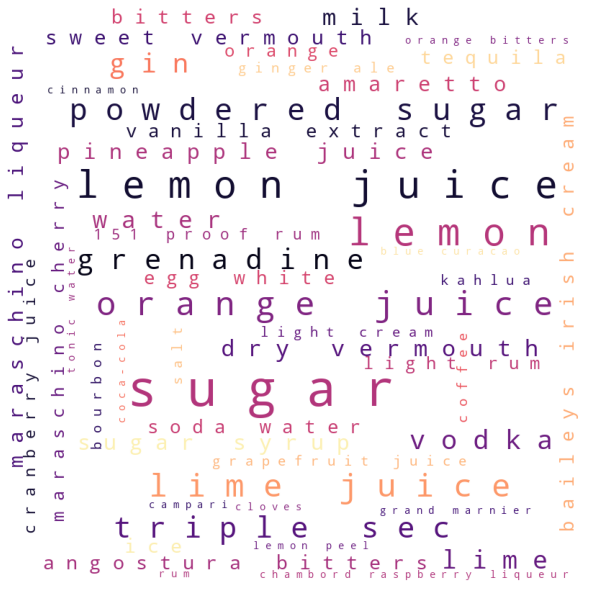

In [ ]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
all_ingredients = ' '.join(cocktail_df['Ingredients'].sum())


ingredient_freq = {}
for ingredient in all_ingredients.split(','):
    ingredient_freq[ingredient] = ingredient_freq.get(ingredient, 0) + 1

# Create a word cloud of the most frequent ingredients
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='magma', max_words=50).generate_from_frequencies(ingredient_freq)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()   

Visualizing the clusters

After carefully expecting the clusters we can conclude that the model picked up 'sweet' and "fruity" flavour profile in an unsupervised manner (and also ‘sweet-sour’, 'coffee',  'creamy,' to some extent). The model also accounts for synonums. 

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

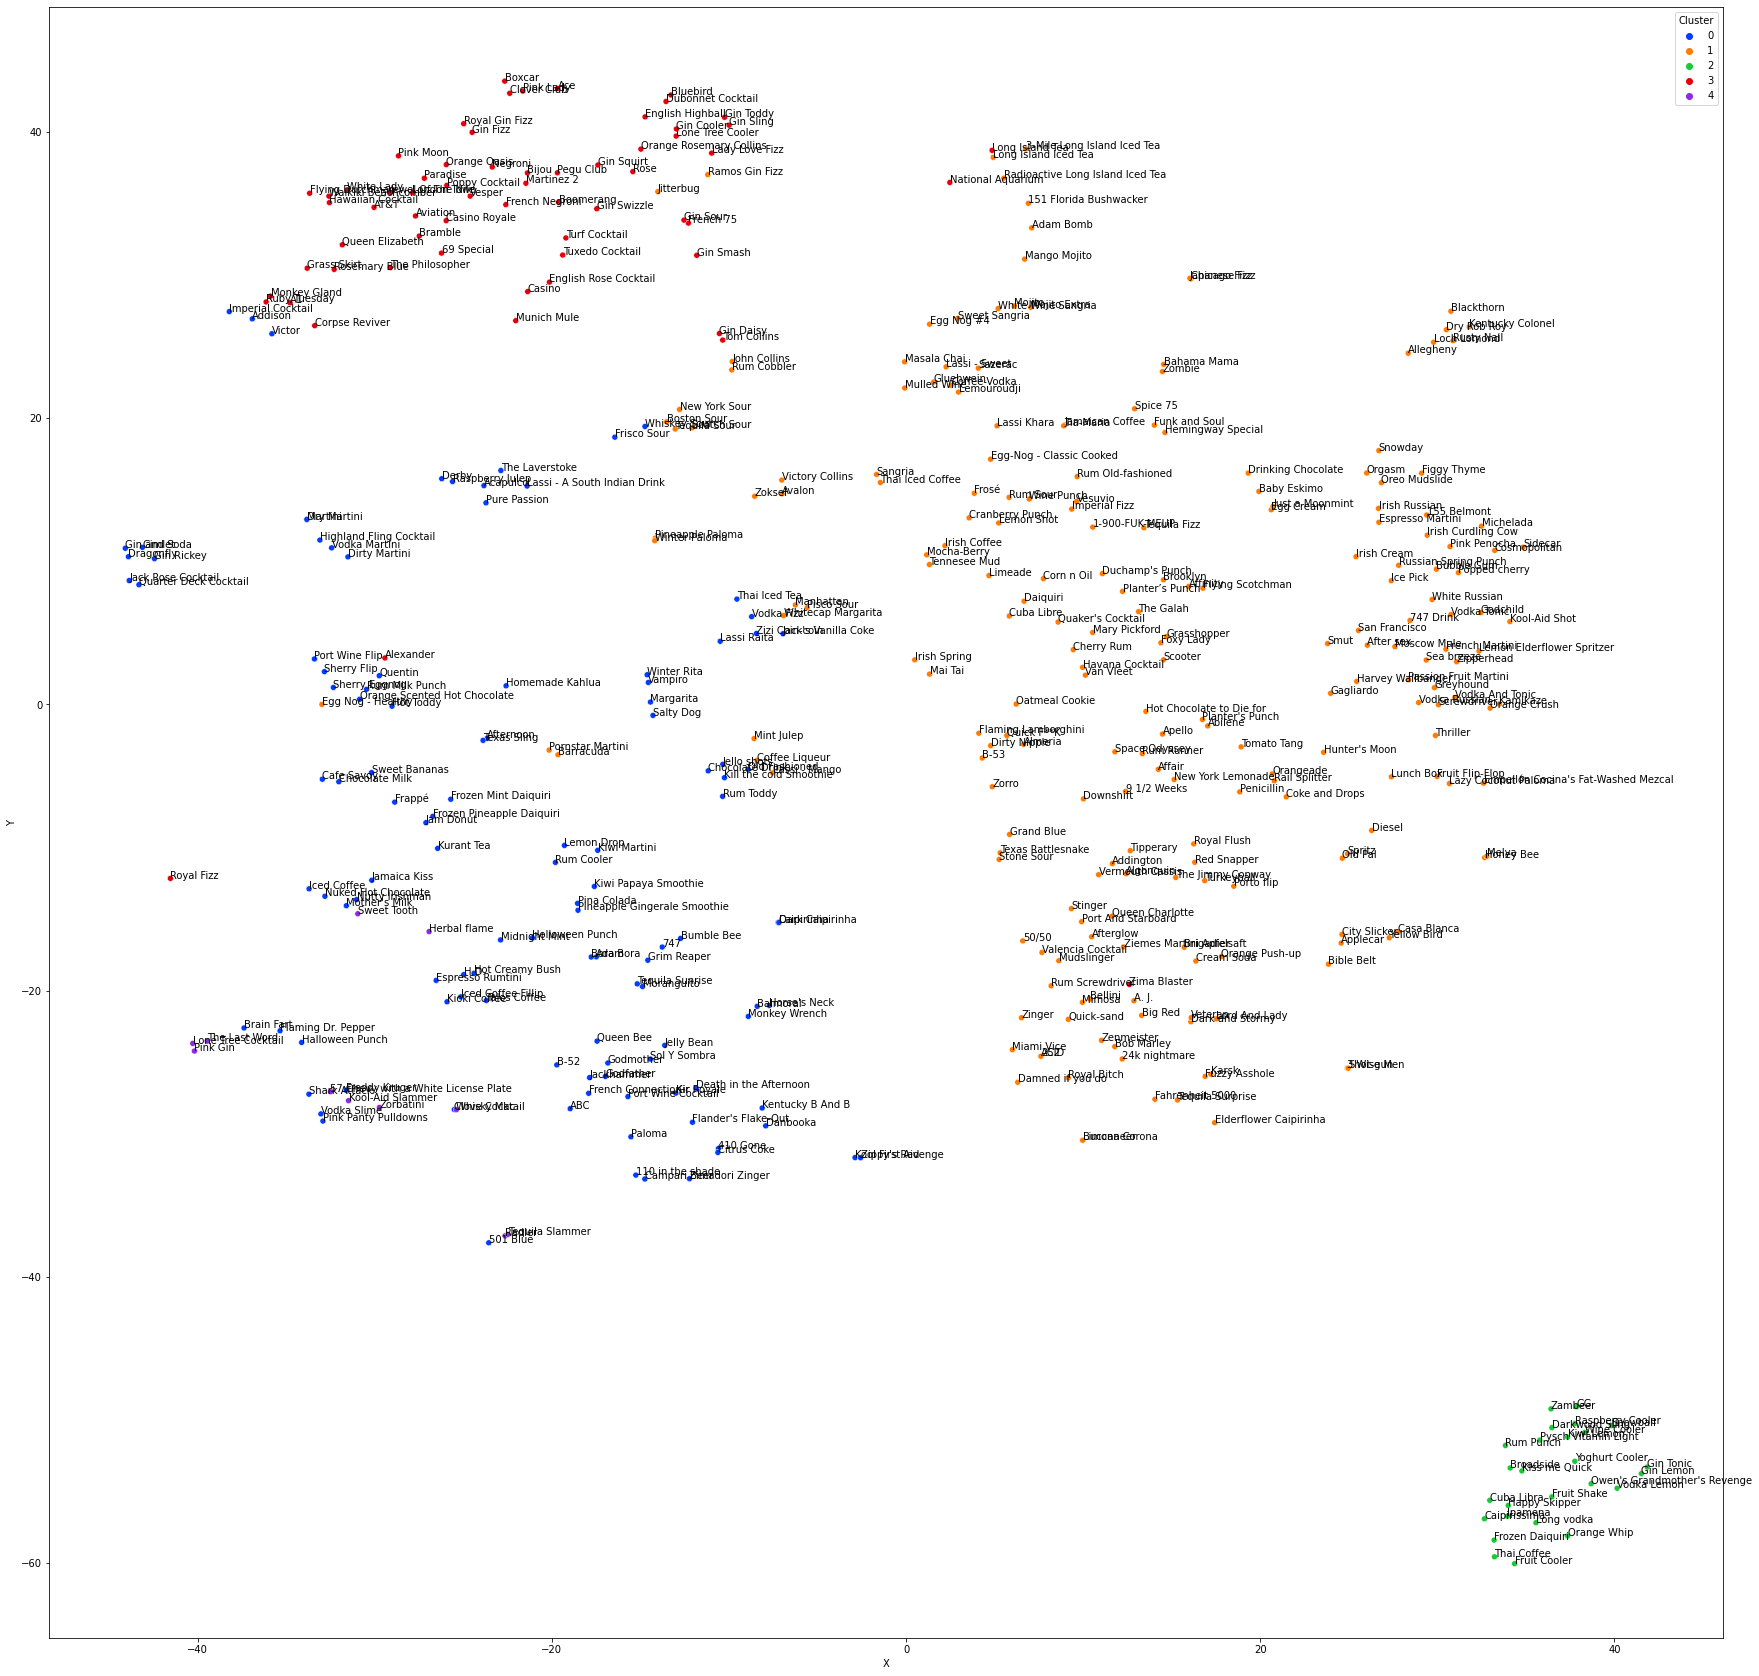

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from google.colab import files

cocktail_df1 = pd.DataFrame(recipe_embeddings)
cocktail_df1 = cocktail_df1.T

# K-means clustering
kmeans = KMeans(n_clusters=5) #5
labels = kmeans.fit_predict(cocktail_df1)
kmeans_df = pd.DataFrame({'X': tsne_vec['X'], 'Y': tsne_vec['Y'], 'Cluster': labels})


plt.figure(figsize=(30, 30))
ax = sns.scatterplot(x=kmeans_df['X'], y=kmeans_df['Y'], hue=kmeans_df['Cluster'], palette='bright')

for i, name in enumerate(cocktail_df1.T):
    ax.annotate(name, (kmeans_df['X'][i], kmeans_df['Y'][i]))

plt.savefig('Scatter_plot.png')
files.download('Scatter_plot.png')